In [462]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
import time

In [463]:
filename = os.listdir('./data')
filename

['baboon.raw', 'lena.raw', 'Noisy.raw', 'F16.raw']

In [464]:
all_img = []
all_1Dimg = []
for i in filename:
    raw = np.fromfile(os.path.join('./data', i), dtype='uint8')
    all_img.append(raw.reshape(512,512))
    all_1Dimg.append(raw)

In [465]:
# raw圖片處理
def data_raw_img(path):
    img = np.fromfile(path, dtype='uint8')
    img = img.reshape(512,512)
    #img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    return img

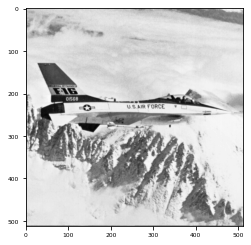

In [466]:
img = data_raw_img(os.path.join('./data', 'F16.raw'))
plt.imshow(img, cmap ='gray')

# Discrete Fourier Transform (DFT)
https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/#The-Discrete-Fourier-Transform

In [467]:
def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [468]:
def padding(x):
    h,w = x.shape
    img = np.zeros(shape=(h*2,w*2))
    img[0:h,0:w] =  x
    return img

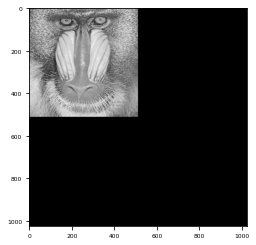

In [469]:
img = padding(all_img[0])
plt.imshow(img,cmap='gray')

In [470]:
def FFT(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    N_min = min(N, 32)
    
    # Perform an O[N^2] DFT on all length-N_min sub-problems at once
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, :int(X.shape[1] / 2)]
        X_odd = X[:, int(X.shape[1] / 2):]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0]) / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

def IFFT(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    N_min = min(N, 32)
    
    # Perform an O[N^2] DFT on all length-N_min sub-problems at once
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))
    #print(X.shape)

    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, :int(X.shape[1] / 2)]
        X_odd = X[:, int(X.shape[1] / 2):]
        factor = np.exp(1j * np.pi * np.arange(X.shape[0]) / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    X = X.ravel()
    X = X / X.shape[0]
    #print( X.shape[0])
    return X

In [724]:
# Fast fourier transform 2D

def FFT2(x):
    FFT_along_row = np.apply_along_axis(FFT, axis=1, arr=x)
    FFT_along_row_col = np.apply_along_axis(FFT, axis=0, arr=FFT_along_row)
    return FFT_along_row_col

def IFFT2(x):
    IFFT_along_row = np.apply_along_axis(IFFT, axis=1, arr=x)
    IFFT_along_row_col = np.apply_along_axis(IFFT, axis=0, arr=IFFT_along_row)
    return IFFT_along_row_col

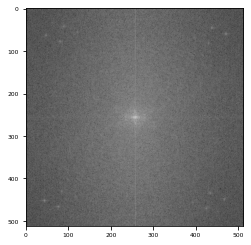

In [763]:
t = np.asarray(all_img[0]).astype('float')
FFT2_img = FFT2(t)
fimg = np.log(np.abs(FFT2_img))
F = fftshift(fimg)
#F = fftshift(fimg)
plt.imshow(F,cmap='gray')

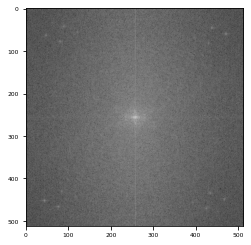

In [764]:
IFFT2_img = IFFT2(FFT2_img)
plt.imshow(F,cmap='gray')

In [734]:
def fftshift(F):
    M, N = F.shape
    R1, R2 = F[0: int(M/2), 0: int(N/2)], F[int(M/2): M, 0: int(N/2)]
    R3, R4 = F[0: int(M/2), int(N/2): N], F[int(M/2): M, int(N/2): N]
    sF = np.zeros(F.shape,dtype = F.dtype)
    sF[int(M/2): M, int(N/2): N], sF[0: int(M/2), 0: int(N/2)] = R1, R4
    sF[int(M/2): M, 0: int(N/2)], sF[0: int(M/2), int(N/2): N]= R3, R2
    return sF

In [743]:
def plot_fftdomain(img):
    FFT2_img = FFT2(img)
    fimg = np.log(np.abs(FFT2_img))
    F = fftshift(fimg)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(img,cmap='gray')
    plt.title('Original Image', fontsize=10)
    
    plt.subplot(1, 3, 2)
    plt.imshow(fimg,cmap='gray')
    plt.title('FFT', fontsize=10)
    
    plt.subplot(1, 3, 3)
    plt.imshow(F,cmap='gray')
    plt.title('FFT shift', fontsize=10)
    return FFT2_img

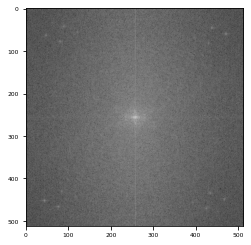

In [757]:
FFT2_img = FFT2(all_img[0])
fimg = np.log(np.abs(FFT2_img))
F = fftshift(fimg)
#F = fftshift(fimg)
plt.imshow(F,cmap='gray')

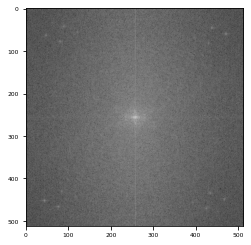

In [745]:
FFT2_img = FFT2(all_img[0])
fimg = np.log(np.abs(FFT2_img))
F = fftshift(fimg)
plt.imshow(F,cmap='gray')

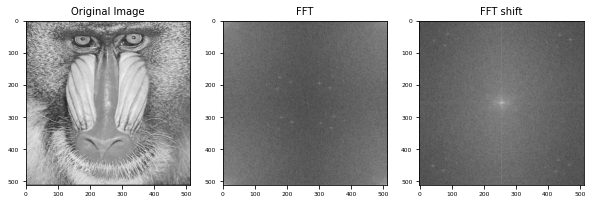

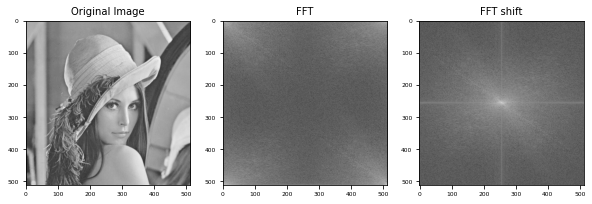

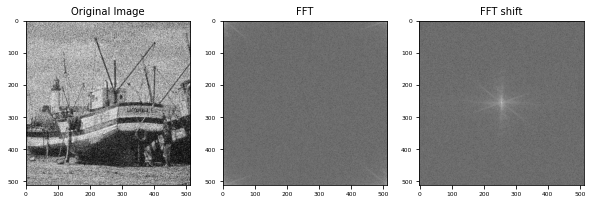

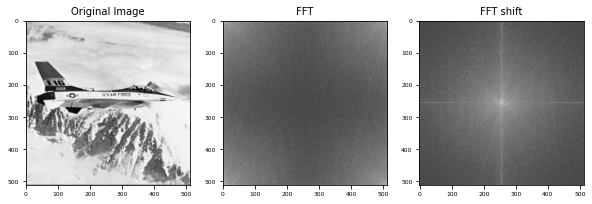

In [746]:
for img in all_img:
    a =plot_fftdomain(img)

In [504]:
def plot_ffthist(img):
    FFT2_img = FFT2(img)
    fimg = np.log(np.abs(FFT2_img))
    F = fftshift(fimg)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img,cmap='gray')
    plt.title('Original Image', fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.hist(fimg)
    plt.title('Histogram of spectrum', fontsize=10)

    return FFT2_img

Text(0.5, 1.0, 'Histogram of spectrum')

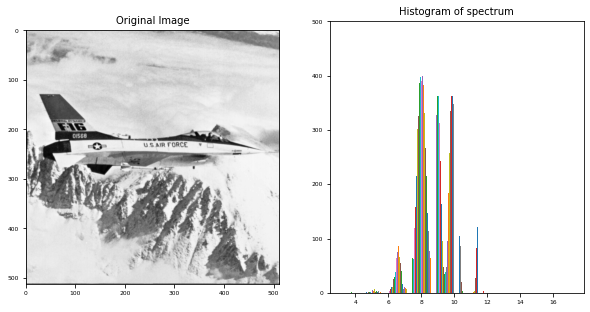

In [506]:
# plot hist
FFT2_img = FFT2(all_img[0])
fimg = np.log(np.abs(FFT2_img))
F = fftshift(fimg)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap='gray')
plt.title('Original Image', fontsize=10)

plt.subplot(1, 2, 2)
plt.hist(fimg)
plt.title('Histogram of spectrum', fontsize=10)

8.698331465324971
7.602743848934791
9.867608145882118
7.641362955084707


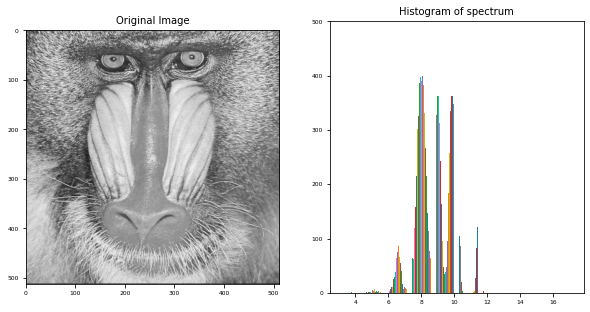

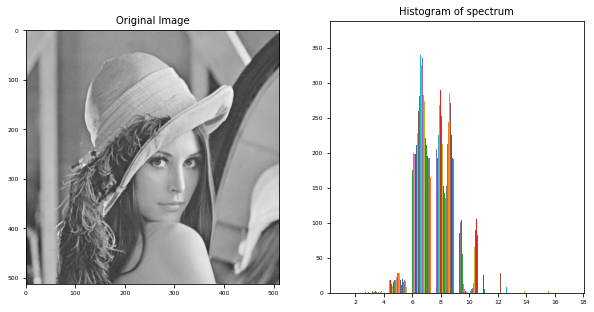

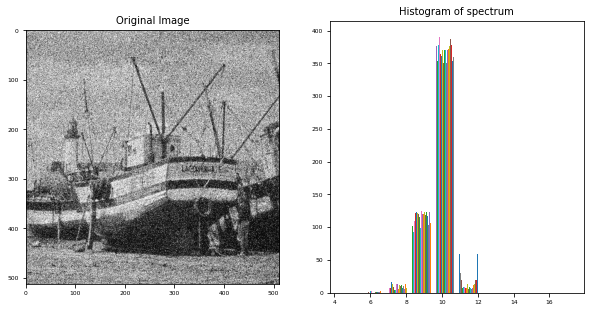

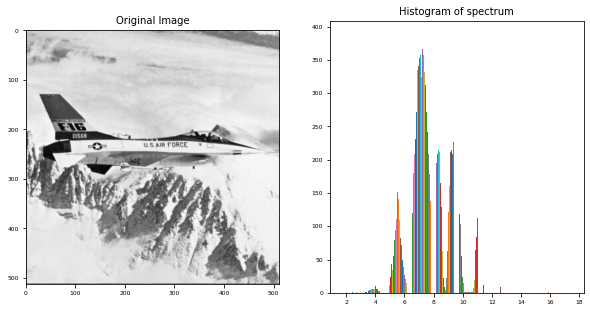

In [505]:
for img in all_img:
    a =plot_ffthist(img)

In [507]:
# plot IFFT 
def plot_IFFT(img):
    FFT2_img = FFT2(all_img[0])
    IFFT2_img = IFFT2(FFT2_img)
    plt.imshow(abs(IFFT2_img),cmap='gray')
    return IFFT2_img

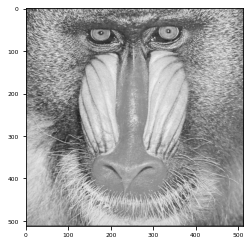

In [259]:
plt.imshow(abs(IFFT2_img),cmap='gray')

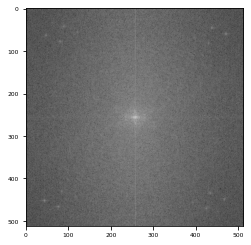

In [255]:
# 套件版做確認
fft_a = np.fft.fft2(all_img[0])
F = fftshift(fft_a)
fimg1 = np.log(np.abs(F))
fimg2 = np.log(np.abs(fft_a))
plt.imshow(fimg1,cmap='gray')

#  Low-pass filter
https://github.com/ShashwatNigam99/Digital_Image_Processing_Assignments/blob/master/assignment3/src/q2.m

In [531]:
# 0：Gaussian, 1：uniform
def add_noise(distribution,img):
    noisy = []
    mean,var = img.mean(), img.var()
    if distribution==0:
        noise = np.random.normal(0, 50, img.shape)
    else:
        noise = np.random.uniform(0, 100, img.shape)
    n = img + noise
    # avoid going over bounds
    n[n > 255] = 255
    n[n < 0] = 0
    n = np.array(n).astype(np.uint8)
    #n = n.reshape(512,512)
    return n

In [532]:
# import random
# for i in range(100):
#     h_set = random.randrange(0,512)
#     w_set = random.randrange(0,512)
#     noisy = np.zeros((img.shape))
#     noisy[h_set, w_set] = np.random.normal(mean, var, 1)[0]
# plt.imshow(noisy, cmap='gray')

In [533]:
def plot_noiseimg(img):
    noisy_Gaussian = add_noise(0, img)
    noisy_uniform = add_noise(1, img)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_Gaussian,cmap='gray')
    plt.title('Add noise by Gaussian', fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_uniform,cmap='gray')
    plt.title('Add noise by Uniform', fontsize=10)
    return 


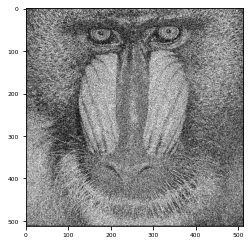

In [762]:
t = np.asarray(all_img[0]).astype('float')
n= add_noise(0,t)
plt.imshow(n)

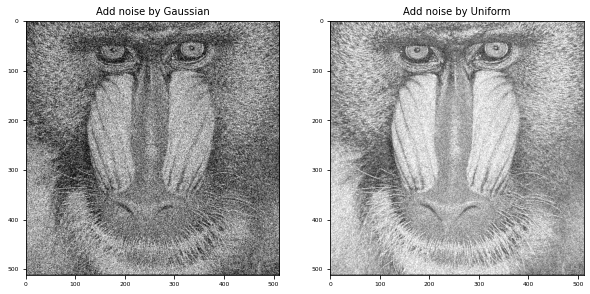

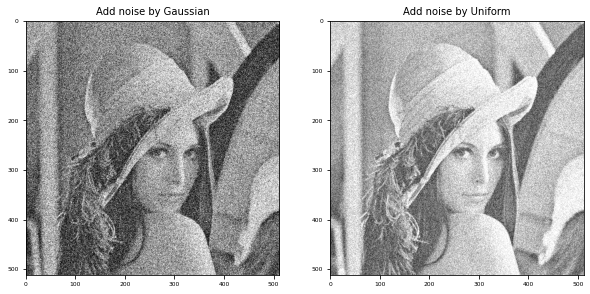

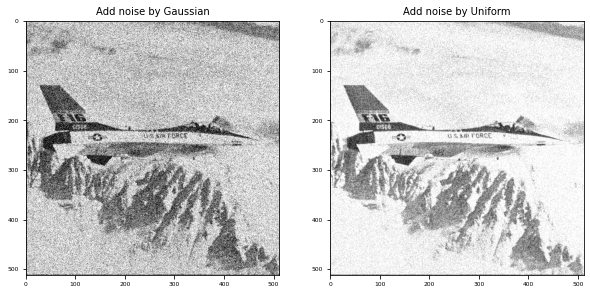

In [534]:
for i in [0,1,3]:
    img = all_img[i]
    plot_noiseimg(img)

In [56]:
#noisy
FFT2_img = FFT2(noisy)
#fimg = np.log(np.abs(FFT2_img))
fft_shift = fftshift(FFT2_img)

In [747]:
def idea_Low_pass_filter(img, D=50):
    # 做FFT
    FFT2_img = FFT2(img)
    #fimg = np.log(np.abs(FFT2_img))
    fft_shift = fftshift(FFT2_img)
    
    #Low_pass_filter
    but_fil = np.zeros((img.shape))
    M, N =img.shape
    for i in range(M):
        for j in range(N):
            duv = ((i-(M/2))**2 + (j-(N/2))**2)**0.5
            if duv>D:
                but_fil[i,j]=0
            else:
                but_fil[i,j]=1
            #but_fil[i,j] = 1/(1+(duv/d)**(2*n))
    
    but_filt_fft = fft_shift*(but_fil)
    but_filtered_img = abs(IFFT2(fftshift(but_filt_fft)))
    plt.imshow(but_filtered_img, cmap='gray')
    return but_fil

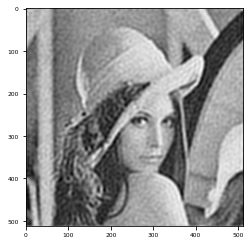

In [748]:
noisy = add_noise(1, all_img[1])
plt.imshow(noisy, cmap='gray')
a= idea_Low_pass_filter(noisy, D=50)

In [750]:
# idea_Low_pass 去躁結果展示
def plot_idea_Low_pass(img):
    noisy_Gaussian = add_noise(0, img)
    noisy_uniform = add_noise(1, img)
    
    #FFT2_img_G = FFT2(noisy_Gaussian)
    #fft_shift_G = fftshift(FFT2_img_G)
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(noisy_Gaussian,cmap='gray')
    plt.title('Add noise by Gaussian', fontsize=10)
    
    plt.subplot(1, 4, 2)
    plt.imshow(noisy_uniform,cmap='gray')
    plt.title('Add noise by Uniform', fontsize=10)

    
    plt.subplot(1, 4, 3)
    denoise_G = idea_Low_pass_filter(noisy_Gaussian, D=60)
    plt.title('Idea_Low_pass de Gaussian', fontsize=10)
    #FFT2_img_U = FFT2(noisy_uniform)
    #fft_shift_U = fftshift(FFT2_img_U)
    plt.subplot(1, 4, 4)
    denoise_U = idea_Low_pass_filter(noisy_uniform, D=60)
    plt.title('Idea_Low_pass de Uniform', fontsize=10)
    

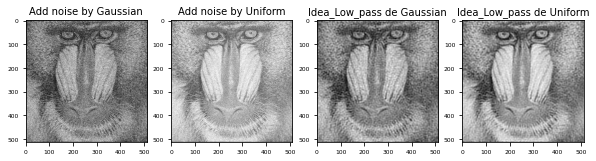

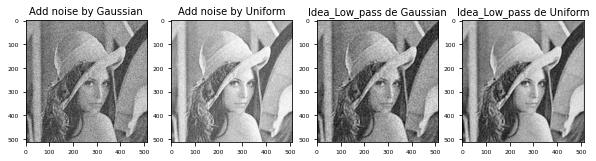

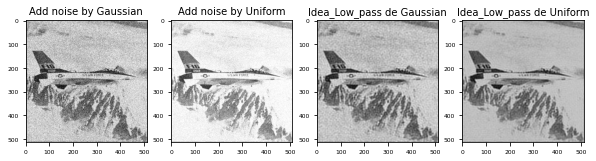

In [543]:
for i in [0,1,3]:
    img = all_img[i]
    plot_idea_Low_pass(img)

In [565]:
def gaussian_Low_pass_filter(img):
    FFT2_img = FFT2(img)
    #fimg = np.log(np.abs(FFT2_img))
    fft_shift = fftshift(FFT2_img)
    
    but_fil = np.zeros((img.shape))
    M, N =img.shape
    sigam= np.sqrt(np.var(img))

    for i in range(M):
        for j in range(N):
            duv = ((i-(M/2))**2 + (j-(N/2))**2)**0.5
            but_fil[i,j] = np.exp(-duv**2/(2*sigam))
    but_filt_fft = fft_shift*(but_fil)
    but_filtered_img = abs(IFFT2(fftshift(but_filt_fft)))
    plt.imshow(but_filtered_img, cmap='gray')
    return but_fil

In [566]:
# idea_Low_pass 去躁結果展示
def plot_gaussian_Low_pass(img):
    noisy_Gaussian = add_noise(0, img)
    noisy_uniform = add_noise(1, img)
    
    #FFT2_img_G = FFT2(noisy_Gaussian)
    #fft_shift_G = fftshift(FFT2_img_G)
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(noisy_Gaussian,cmap='gray')
    plt.title('Add noise by Gaussian', fontsize=10)
    
    plt.subplot(1, 4, 2)
    plt.imshow(noisy_uniform,cmap='gray')
    plt.title('Add noise by Uniform', fontsize=10)

    
    plt.subplot(1, 4, 3)
    denoise_G = gaussian_Low_pass_filter(noisy_Gaussian)
    plt.title('Gaussian_Low_pass de Gaussian', fontsize=10)
    #FFT2_img_U = FFT2(noisy_uniform)
    #fft_shift_U = fftshift(FFT2_img_U)
    plt.subplot(1, 4, 4)
    denoise_U = gaussian_Low_pass_filter(noisy_uniform)
    plt.title('Gaussian_Low_pass de Uniform', fontsize=10)
    

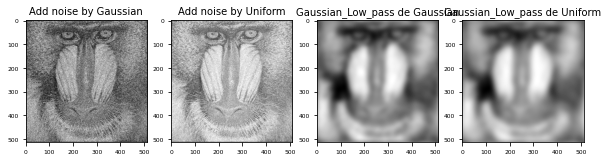

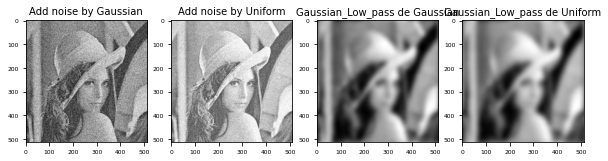

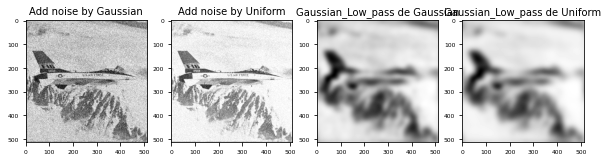

In [567]:
for i in [0,1,3]:
    img = all_img[i]
    plot_gaussian_Low_pass(img)

In [584]:
# try
but_fil = np.zeros((noisy.shape))
M, N =noisy.shape
D = 100
n = 2
for i in range(M):
    for j in range(N):
        duv = ((i-(M/2))**2 + (j-(N/2))**2)**0.5
        if duv>D:
            but_fil[i,j]=0
        else:
            but_fil[i,j]=1
        #but_fil[i,j] = 1/(1+(duv/d)**(2*n))



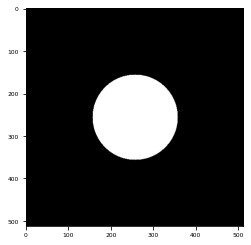

In [585]:
plt.imshow(but_fil, cmap='gray')

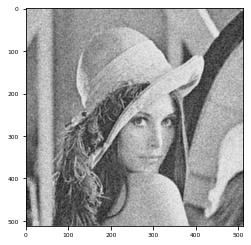

In [587]:
#imshow(but_fil,[])
#noisy
FFT2_img = FFT2(noisy)
#fimg = np.log(np.abs(FFT2_img))
fft_shift = fftshift(FFT2_img)

but_filt_fft = fft_shift*(but_fil)
but_filtered_img = abs(IFFT2(fftshift(but_filt_fft)))
plt.imshow(but_filtered_img, cmap='gray')


# High pass filter

In [637]:
def idea_high_pass_filter(img, Threshold=50):
    # 做FFT
    FFT2_img = FFT2(img)
    #fimg = np.log(np.abs(FFT2_img))
    fft_shift = fftshift(FFT2_img)
    
    #Low_pass_filter
    but_fil = np.zeros((img.shape))
    M, N =img.shape
    for i in range(M):
        for j in range(N):
            duv = ((i-(M/2))**2 + (j-(N/2))**2)**0.5
            if duv<Threshold:
                but_fil[i,j]=0
            else:
                but_fil[i,j]=1
            #but_fil[i,j] = 1/(1+(duv/d)**(2*n))
    
    but_filt_fft = fft_shift*(but_fil)
    but_filtered_img = abs(IFFT2(fftshift(but_filt_fft)))
    plt.imshow(but_filtered_img, cmap='gray')
    plt.title('Idea high pass', fontsize=10)
    return but_fil

In [606]:
def Butterworth_high_pass_filter(img, D=50, n=2):
    # 做FFT
    FFT2_img = FFT2(img)
    #fimg = np.log(np.abs(FFT2_img))
    fft_shift = fftshift(FFT2_img)
    
    #Low_pass_filter
    but_fil = np.zeros((img.shape))
    M, N =img.shape
    for i in range(M):
        for j in range(N):
            duv = ((i-(M/2))**2 + (j-(N/2))**2)**0.5
            but_fil[i,j] = 1/(1+(duv/D)**(2*n))
    
    but_filt_fft = fft_shift*(1-but_fil)
    but_filtered_img = abs(IFFT2(fftshift(but_filt_fft)))
    #print(but_filtered_img.min(),but_filtered_img.max())
    but_filtered_img = (but_filtered_img-np.amin(but_filtered_img))/(np.amax(but_filtered_img)-np.amin(but_filtered_img))
    plt.imshow(but_filtered_img, cmap='gray')
    plt.title('Butterworth high pass', fontsize=10)
    return but_fil

In [634]:
# 邊緣檢測-2 Laplacian
class Laplacian_Filter():
    #初始化
    def __init__(self, kernal_size=3):
        self.kernal_size=kernal_size
    
    # 濾波函數
    def filter(self, img):
        img = np.array(img)
        height = img.shape[0]
        width = img.shape[1]
        newimg = np.zeros((height, width))
        halfk= int((self.kernal_size-1)/2)
        if self.kernal_size ==3:
            template = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]]) #建立3*3濾波模板
        elif self.kernal_size ==5:
            #template = np.array([[0,0,1,0,0], [0,0,2,0,0], [1,2,-16,2,1],[0,0,2,0,0],[0,0,1,0,0]]) #建立5*5濾波模板
            template = np.array([[0,0,-1,0,0], [0,0,-2,0,0], [-1,-2,16,-2,-1],[0,0,-2,0,0],[0,0,-1,0,0]])
        
        
        for i in range(halfk, height-halfk):
            for j in range(halfk, width-halfk):
                img_f = img[i-halfk:i+halfk+1, j-halfk:j+halfk+1]
                kernal_f = np.multiply(img_f, template)
                newimg[i, j] = kernal_f.sum()
        newImage = Image.fromarray(newimg)
        return newimg
    
def Do_Laplacian_Filter(img, kernal_size):
    if kernal_size%2==0:
        print('Kernal size please enter an odd value！')
    else:
        Lap_Filter=Laplacian_Filter(kernal_size)#宣告高斯模糊類
        image = Lap_Filter.filter(img)
        #print(image)
        #print(image.min(),image.max())
        #image = (image-np.min(image))/(np.max(image)-np.min(image))
        image = np.uint8(image)
        plt.imshow(image, cmap='gray')#圖片顯示

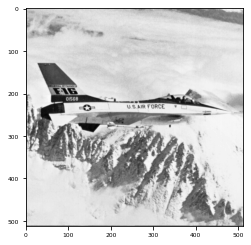

In [635]:
plt.imshow(img, cmap='gray')

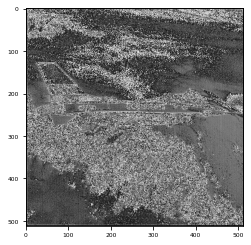

In [636]:
Do_Laplacian_Filter(img, 5)

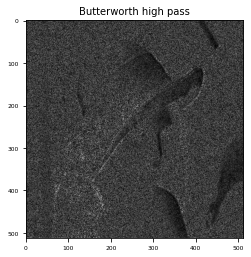

In [610]:
a=Butterworth_high_pass_filter(noisy, D=50, n=2)

In [638]:
# idea_Low_pass 去躁結果展示
def plot_high_pass(img):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(img,cmap='gray')
    plt.title('Original Image', fontsize=10)
    
    plt.subplot(1, 4, 2)
    idea_high_pass_img = idea_high_pass_filter(img, 50)
    plt.title('Idea high pass', fontsize=10)

    plt.subplot(1, 4, 3)
    Butterworth_high_pass_img = Butterworth_high_pass_filter(img)
    plt.title('Butterworth high pass', fontsize=10)
    
    plt.subplot(1, 4, 4)
    Laplacian_Filter_img = Do_Laplacian_Filter(img, 5)
    plt.title('Laplacian Filter', fontsize=10)

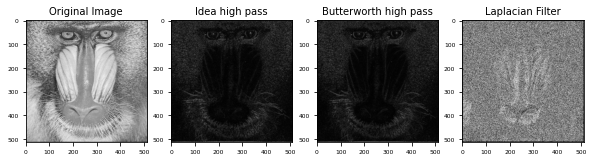

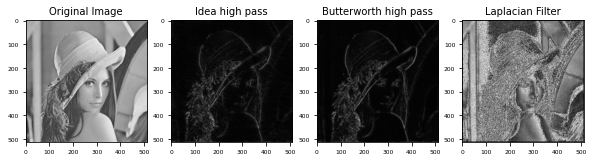

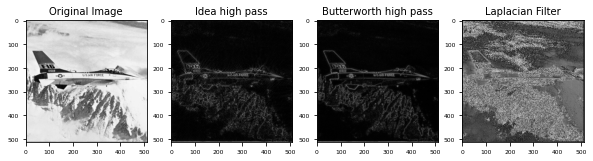

In [612]:
for i in [0,1,3]:
    img = all_img[i]
    plot_high_pass(img)

# Image denoising

In [645]:
# Inverse-Filtering
def Inverse_Filtering(img):
    
    F = FFT2(img)
    F2 = fftshift( F )

    # normalize to [0,1]
    H = img/255.

    # calculate the damaged image
    G = H * F2

    # Inverse Filter 
    F_hat = G / H

    # cheat? replace division by zero (NaN) with zeroes
    a = np.nan_to_num(F_hat)
    f_hat = np.fft.ifft2(fftshift(a) )
    f_hat = abs(f_hat)
    plt.imshow(f_hat, cmap='gray')
    return f_hat

/home/re6091054/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


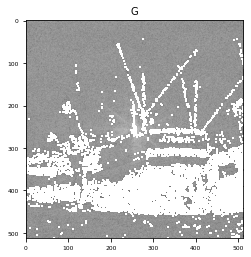

/home/re6091054/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


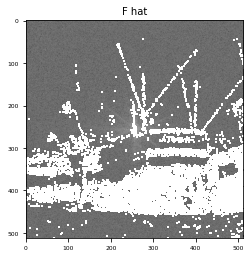

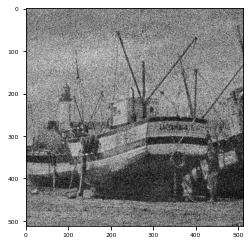

In [673]:
# Try Inverse-Filtering
F = FFT2(all_img[2])
F2 = fftshift( F )

# normalize to [0,1]
H = all_img[2]/255.

# calculate the damaged image
G = H * F2
plt.imshow(np.log(np.abs(G)), cmap='gray')
plt.title('G', fontsize=10)
plt.show()

# Inverse Filter 
F_hat = G / H
plt.imshow(np.log(np.abs(F_hat)), cmap='gray')
plt.title('F hat', fontsize=10)
plt.show()

# cheat? replace division by zero (NaN) with zeroes
a = np.nan_to_num(F_hat)
f_hat = np.fft.ifft2( fftshift(a) )
f_hat = abs(f_hat)
plt.imshow(f_hat, cmap='gray')

/home/re6091054/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Text(0.5, 1.0, 'After Inverse Filtering')

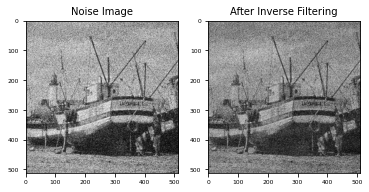

In [663]:
plt.subplot(1,2,1)
plt.imshow(all_img[2], cmap='gray')
plt.title('Noise Image', fontsize=10)

plt.subplot(1,2,2)
Inverse_Filtering(all_img[2])
plt.title('After Inverse Filtering', fontsize=10)

# Wiener filter
- https://github.com/lvxiaoxin/Wiener-filter/blob/master/main.py
- https://github.com/tranleanh/wiener-filter-image-restoration

In [ ]:
# 仿真运动模糊
def motion_process(len=100, size):
    sx, sy = size
    PSF = np.zeros((sy, sx))
    PSF[int(sy / 2):int(sy /2 + 1), int(sx / 2 - len / 2):int(sx / 2 + len / 2)] = 1
    return PSF / PSF.sum() # 归一化亮度

def make_blurred(input, PSF, eps):
    input_fft = FFT2(input)
    PSF_fft = FFT2(PSF) + eps
    blurred = IFFT2(input_fft * PSF_fft)
    blurred = np.abs(fftshift(blurred))
    return blurred

def wiener(input, PSF, eps):
    input_fft = FFT2(input)
    W = FFT2(PSF) + eps #噪声功率，这是已知的，考虑epsilon
    result = IFFT2(input_fft / W) #计算F(u,v)的傅里叶反变换
    result = np.abs(fftshift(result))
    return result

In [700]:
def wiener_filter(img):
    PSF = motion_process(100, img.shape)
    blurred = make_blurred(img, PSF, 1e-3)
    result = wiener(blurred, PSF, 1e-3)
    
    plt.subplot(1,2,1)
    plt.imshow(blurred, cmap='gray')
    plt.title('with Motion blurred', fontsize=10)

    plt.subplot(1,2,2)
    plt.imshow(result)
    plt.title('After Wiener Filtering', fontsize=10)

    return result

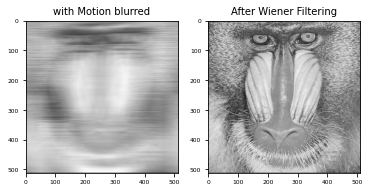

In [702]:
wiener = wiener_filter(all_img[0])

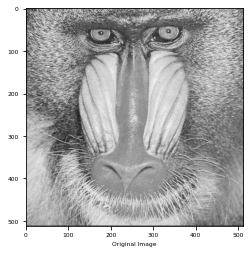

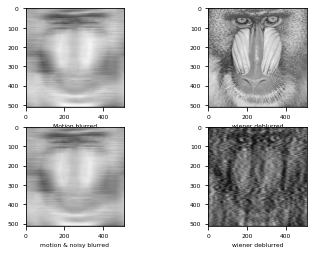

In [693]:
image = all_img[0]
plt.figure(1)
plt.xlabel("Original Image")
plt.gray()
plt.imshow(image)

plt.figure(2)
plt.gray()
data = image
PSF = motion_process(100, data.shape)
blurred = make_blurred(data, PSF, 1e-3)

plt.subplot(221)
plt.xlabel("Motion blurred")
plt.imshow(blurred)

result = wiener(blurred, PSF, 1e-3)
plt.subplot(222)
plt.xlabel("wiener deblurred")
plt.imshow(result)

blurred = 0.1 * blurred.std() * numpy.random.standard_normal(blurred.shape) + blurred

plt.subplot(223)
plt.xlabel("motion & noisy blurred")
plt.imshow(blurred)

result = wiener(blurred, PSF, 0.1 + 1e-3)
plt.subplot(224)
plt.xlabel("wiener deblurred")
plt.imshow(result)

plt.show()

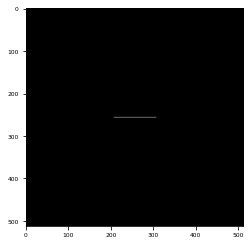

In [694]:
plt.imshow(PSF)

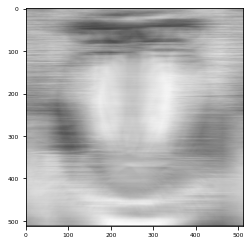

In [695]:
blurred = numpy.abs(make_blurred(data, PSF, 1e-3))
plt.imshow(blurred)

Text(0.5, 1.0, 'After Wiener Filtering')

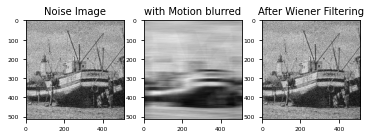

In [683]:
blurred = make_blurred(all_img[2], PSF, 1e-3)
result = wiener(blurred, PSF, 1e-3)

plt.subplot(1,3,1)
plt.imshow(all_img[2], cmap='gray')
plt.title('Noise Image', fontsize=10)

plt.subplot(1,3,2)
plt.imshow(blurred, cmap='gray')
plt.title('with Motion blurred', fontsize=10)

plt.subplot(1,3,3)
plt.imshow(result)
plt.title('After Wiener Filtering', fontsize=10)


Text(0.5, 1.0, 'After Wiener Filtering')

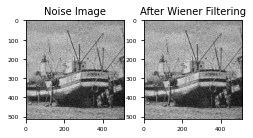

In [691]:
plt.subplot(1,3,1)
plt.imshow(all_img[2], cmap='gray')
plt.title('Noise Image', fontsize=10)

plt.subplot(1,3,2)

PSF = np.zeros((blurred.shape))
result = wiener(all_img[2], PSF, 1e-3)
result = numpy.fft.ifftshift(result)
plt.imshow(result, cmap='gray')
plt.title('After Wiener Filtering', fontsize=10)

# Guided Filter
- https://medium.com/@gary1346aa/%E5%B0%8E%E5%90%91%E6%BF%BE%E6%B3%A2%E7%9A%84%E5%8E%9F%E7%90%86%E4%BB%A5%E5%8F%8A%E5%85%B6%E6%87%89%E7%94%A8-78fdf562e749
- https://github.com/pfchai/GuidedFilter

In [386]:
import numpy as np

def boxfilter(img, r):
    (rows, cols) = img.shape
    imDst = np.zeros_like(img)

    imCum = np.cumsum(img, 0)
    imDst[0 : r+1, :] = imCum[r : 2*r+1, :]
    imDst[r+1 : rows-r, :] = imCum[2*r+1 : rows, :] - imCum[0 : rows-2*r-1, :]
    imDst[rows-r: rows, :] = np.tile(imCum[rows-1, :], [r, 1]) - imCum[rows-2*r-1 : rows-r-1, :]

    imCum = np.cumsum(imDst, 1)
    imDst[:, 0 : r+1] = imCum[:, r : 2*r+1]
    imDst[:, r+1 : cols-r] = imCum[:, 2*r+1 : cols] - imCum[:, 0 : cols-2*r-1]
    imDst[:, cols-r: cols] = np.tile(imCum[:, cols-1], [r, 1]).T - imCum[:, cols-2*r-1 : cols-r-1]

    return imDst


def guidedfilter(I, p, r, eps):
    if I.max()>1:
        I = I/255.0
    if p.max()>1:
        p = p/255.0
        
    (rows, cols) = I.shape
    N = boxfilter(np.ones([rows, cols]), r)

    meanI = boxfilter(I, r) / N
    meanP = boxfilter(p, r) / N
    meanIp = boxfilter(I * p, r) / N
    covIp = meanIp - meanI * meanP

    meanII = boxfilter(I * I, r) / N
    varI = meanII - meanI * meanI

    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = boxfilter(a, r) / N
    meanB = boxfilter(b, r) / N

    q = meanA * I + meanB
    
    plt.imshow(q ,cmap='gray')
    return q

In [333]:
def Bilateral_filter( img_in, sigma_c, sigma_s, kernal_size ):

    # check the input
#     if not isinstance( img_in, np.ndarray ) or img_in.dtype != 'float32' or img_in.ndim != 2:
#         raise ValueError('Expected a 2D numpy.ndarray with float32 elements')
    img = img_in.astype(np.float32)/255.0

    # make a simple Gaussian function taking the squared radius
    gaussian = lambda r2, sigma: (np.exp(-r2**2/(2*sigma**2)))

    img = np.array(img)
    height = img.shape[0]
    width = img.shape[1]
    newimg = np.zeros((height, width))
    halfk= int((kernal_size-1)/2)

    
    sideLength = kernal_size
    W_c = np.zeros((sideLength, sideLength))
    for i in range(sideLength):
        for j in range(sideLength):
            W_c[i, j] = gaussian((i-(kernal_size-1)/2)**2+(j-(kernal_size-1)/2)**2, sigma_c )
            
    newdata = np.zeros((height, width))            
    for i in range(halfk, height-halfk):
        for j in range(halfk, width-halfk):
            r2_s = img[i,j]-img[i-halfk:i+halfk+1, j-halfk:j+halfk+1]
            W_s = gaussian(r2_s, sigma_s)
            
            result = W_c*W_s*img[i-halfk:i+halfk+1, j-halfk:j+halfk+1]
            wgt_sum = W_c*W_s
            newdata[i, j] = (result.sum()/wgt_sum.sum())
    #newImage = Image.fromarray(newimg)

    # normalize the result and return
    return newdata

Text(0.5, 1.0, 'After Guided Filter')

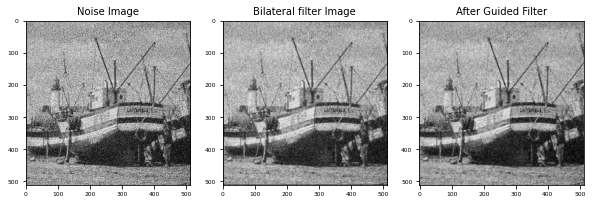

In [707]:
# plot Guided filter
plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.imshow(all_img[2], cmap='gray')
plt.title('Noise Image', fontsize=10)

plt.subplot(1,3,2)
B_image = Bilateral_filter(all_img[2], 15, 35, 3)
plt.imshow(B_image, cmap='gray')
plt.title('Bilateral filter Image', fontsize=10)

plt.subplot(1,3,3)
g = guidedfilter(B_image, all_img[2], 1, 0.01)
plt.title('After Guided Filter', fontsize=10)



# DCT
- https://github.com/zafarrafii/Zaf-Python

In [390]:
# def dct(audio_signal, dct_type):
#     """
#     Compute the discrete cosine transform (DCT) using the fast Fourier transform (FFT).
#     Inputs:
#         audio_signal: audio signal (window_length,)
#         dct_type: DCT type (1, 2, 3, or 4)
#     Output:
#         audio_dct: audio DCT (number_frequencies,)
#     Example: Compute the 4 different DCTs and compare them to SciPy's DCTs.
#         # Import the needed modules
#         import numpy as np
#         import zaf
#         import scipy.fftpack
#         import matplotlib.pyplot as plt
#         # Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
#         audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
#         audio_signal = np.mean(audio_signal, 1)
#         # Get an audio segment for a given window length
#         window_length = 1024
#         audio_segment = audio_signal[0:window_length]
#         # Compute the DCT-I, II, III, and IV
#         audio_dct1 = zaf.dct(audio_segment, 1)
#         audio_dct2 = zaf.dct(audio_segment, 2)
#         audio_dct3 = zaf.dct(audio_segment, 3)
#         audio_dct4 = zaf.dct(audio_segment, 4)
#         # Compute SciPy's DCT-I, II, III, and IV (orthogonalized)
#         scipy_dct1 = scipy.fftpack.dct(audio_segment, type=1, norm="ortho")
#         scipy_dct2 = scipy.fftpack.dct(audio_segment, type=2, norm="ortho")
#         scipy_dct3 = scipy.fftpack.dct(audio_segment, type=3, norm="ortho")
#         scipy_dct4 = scipy.fftpack.dct(audio_segment, type=4, norm="ortho")
#         # Plot the DCT-I, II, III, and IV, SciPy's versions, and their differences
#         plt.figure(figsize=(14, 7))
#         plt.subplot(3, 4, 1), plt.plot(audio_dct1), plt.autoscale(tight=True), plt.title("DCT-I")
#         plt.subplot(3, 4, 2), plt.plot(audio_dct2), plt.autoscale(tight=True), plt.title("DCT-II")
#         plt.subplot(3, 4, 3), plt.plot(audio_dct3), plt.autoscale(tight=True), plt.title("DCT-III")
#         plt.subplot(3, 4, 4), plt.plot(audio_dct4), plt.autoscale(tight=True), plt.title("DCT-IV")
#         plt.subplot(3, 4, 5), plt.plot(scipy_dct1), plt.autoscale(tight=True), plt.title("SciPy's DCT-I")
#         plt.subplot(3, 4, 6), plt.plot(scipy_dct2), plt.autoscale(tight=True), plt.title("SciPy's DCT-II")
#         plt.subplot(3, 4, 7), plt.plot(scipy_dct3), plt.autoscale(tight=True), plt.title("SciPy's DCT-III")
#         plt.subplot(3, 4, 8), plt.plot(scipy_dct4), plt.autoscale(tight=True), plt.title("SciPy's DCT-IV")
#         plt.subplot(3, 4, 9), plt.plot(audio_dct1-scipy_dct1), plt.autoscale(tight=True), plt.title("DCT-I - SciPy's DCT-I")
#         plt.subplot(3, 4, 10), plt.plot(audio_dct2-scipy_dct2), plt.autoscale(tight=True), plt.title("DCT-II - SciPy's DCT-II")
#         plt.subplot(3, 4, 11), plt.plot(audio_dct3-scipy_dct3), plt.autoscale(tight=True), plt.title("DCT-III - SciPy's DCT-III")
#         plt.subplot(3, 4, 12), plt.plot(audio_dct3-scipy_dct3), plt.autoscale(tight=True), plt.title("DCT-IV - SciPy's DCT-IV")
#         plt.tight_layout()
#         plt.show()
#     """

#     # Check if the DCT type is I, II, III, or IV
#     if dct_type == 1:

#         # Get the number of samples
#         window_length = len(audio_signal)

#         # Pre-process the signal to make the DCT-I matrix orthogonal
#         # (copy the signal to avoid modifying it outside of the function)
#         audio_signal = audio_signal.copy()
#         audio_signal[[0, -1]] = audio_signal[[0, -1]] * np.sqrt(2)

#         # Compute the DCT-I using the FFT
#         audio_dct = np.concatenate((audio_signal, audio_signal[-2:0:-1]))
#         audio_dct = np.fft.fft(audio_dct)
#         audio_dct = np.real(audio_dct[0:window_length]) / 2

#         # Post-process the results to make the DCT-I matrix orthogonal
#         audio_dct[[0, -1]] = audio_dct[[0, -1]] / np.sqrt(2)
#         audio_dct = audio_dct * np.sqrt(2 / (window_length - 1))

#         return audio_dct

#     elif dct_type == 2:

#         # Get the number of samples
#         window_length = len(audio_signal)

#         # Compute the DCT-II using the FFT
#         audio_dct = np.zeros(4 * window_length)
#         audio_dct[1 : 2 * window_length : 2] = audio_signal
#         audio_dct[2 * window_length + 1 : 4 * window_length : 2] = audio_signal[::-1]
#         audio_dct = np.fft.fft(audio_dct)
#         audio_dct = np.real(audio_dct[0:window_length]) / 2

#         # Post-process the results to make the DCT-II matrix orthogonal
#         audio_dct[0] = audio_dct[0] / np.sqrt(2)
#         audio_dct = audio_dct * np.sqrt(2 / window_length)

#         return audio_dct

#     elif dct_type == 3:

#         # Get the number of samples
#         window_length = len(audio_signal)

#         # Pre-process the signal to make the DCT-III matrix orthogonal
#         # (copy the signal to avoid modifying it outside of the function)
#         audio_signal = audio_signal.copy()
#         audio_signal[0] = audio_signal[0] * np.sqrt(2)

#         # Compute the DCT-III using the FFT
#         audio_dct = np.zeros(4 * window_length)
#         audio_dct[0:window_length] = audio_signal
#         audio_dct[window_length + 1 : 2 * window_length + 1] = -audio_signal[::-1]
#         audio_dct[2 * window_length + 1 : 3 * window_length] = -audio_signal[1:]
#         audio_dct[3 * window_length + 1 : 4 * window_length] = audio_signal[:0:-1]
#         audio_dct = np.fft.fft(audio_dct)
#         audio_dct = np.real(audio_dct[1 : 2 * window_length : 2]) / 4

#         # Post-process the results to make the DCT-III matrix orthogonal
#         audio_dct = audio_dct * np.sqrt(2 / window_length)

#         return audio_dct

#     elif dct_type == 4:

#         # Get the number of samples
#         window_length = len(audio_signal)

#         # Compute the DCT-IV using the FFT
#         audio_dct = np.zeros(8 * window_length)
#         audio_dct[1 : 2 * window_length : 2] = audio_signal
#         audio_dct[2 * window_length + 1 : 4 * window_length : 2] = -audio_signal[::-1]
#         audio_dct[4 * window_length + 1 : 6 * window_length : 2] = -audio_signal
#         audio_dct[6 * window_length + 1 : 8 * window_length : 2] = audio_signal[::-1]
#         audio_dct = np.fft.fft(audio_dct)
#         audio_dct = np.real(audio_dct[1 : 2 * window_length : 2]) / 4

#         # Post-process the results to make the DCT-IV matrix orthogonal
#         audio_dct = audio_dct * np.sqrt(2 / window_length)

#         return audio_dct

In [418]:
def dct(audio_signal):
    
    # Get the number of samples
    window_length = len(audio_signal)

    # Pre-process the signal to make the DCT-I matrix orthogonal
    # (copy the signal to avoid modifying it outside of the function)
    audio_signal = audio_signal.copy()
    audio_signal[[0, -1]] = audio_signal[[0, -1]] * np.sqrt(2)

    # Compute the DCT-I using the FFT
    audio_dct = np.concatenate((audio_signal, audio_signal[-2:0:-1]))
    audio_dct = np.fft.fft(audio_dct)
    audio_dct = np.real(audio_dct[0:window_length]) / 2

    # Post-process the results to make the DCT-I matrix orthogonal
    audio_dct[[0, -1]] = audio_dct[[0, -1]] / np.sqrt(2)
    audio_dct = audio_dct * np.sqrt(2 / (window_length - 1))

    return audio_dct

   

In [423]:
def Idct(audio_signal):
    
    # Get the number of samples
    window_length = len(audio_signal)

    # Pre-process the signal to make the DCT-I matrix orthogonal
    # (copy the signal to avoid modifying it outside of the function)
    audio_signal = audio_signal.copy()
    audio_signal[[0, -1]] = audio_signal[[0, -1]] * np.sqrt(2)

    # Compute the DCT-I using the FFT
    audio_dct = np.concatenate((audio_signal, audio_signal[-2:0:-1]))
    audio_dct = np.fft.fft(audio_dct)
    audio_dct = np.real(audio_dct[0:window_length]) / 2

    # Post-process the results to make the DCT-I matrix orthogonal
    audio_dct[[0, -1]] = audio_dct[[0, -1]] / np.sqrt(2)
    audio_dct = audio_dct * np.sqrt(2 / (window_length - 1))
    
    audio_dct = audio_dct/audio_dct.shape[0]

    return audio_dct


In [425]:
# Fast fourier transform 2D

def DCT2(x):
    FFT_along_row = np.apply_along_axis(dct, axis=1, arr=x)
    FFT_along_row_col = np.apply_along_axis(dct, axis=0, arr=FFT_along_row)
    return FFT_along_row_col

def IDCT2(x):
    IFFT_along_row = np.apply_along_axis(Idct, axis=1, arr=x)
    IFFT_along_row_col = np.apply_along_axis(Idct, axis=0, arr=IFFT_along_row)
    return IFFT_along_row_col

In [709]:
a= DCT2(all_img[2] )
b= IDCT2(a )

In [766]:
def DCT_ideal_low_pass(img):
    a= DCT2(img )
    mask = np.zeros((img.shape))
    h, w = img.shape
    mask[0:int(3*h/4),0:int(3*w/4)] = 1.
    I = mask*a
    b= IDCT2(I )
    plt.imshow(b,cmap='gray')
    plt.title('After DCT ideal low pass', fontsize=10)
    return b

Text(0.5, 1.0, 'After DCT ideal low pass')

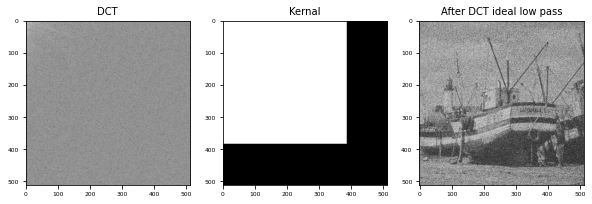

In [711]:
# plot DCT
plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
fimg = np.log(np.abs(a))
plt.imshow(fimg,cmap='gray')
plt.title('DCT', fontsize=10)

plt.subplot(1,3,2)
mask = np.zeros((all_img[2].shape))
h, w = fimg.shape
mask[0:int(3*h/4),0:int(3*w/4)] = 1.
plt.imshow(mask,cmap='gray')
plt.title('Kernal', fontsize=10)

plt.subplot(1,3,3)
a= DCT2(all_img[2] )
I = mask*a
b= IDCT2(I )
plt.imshow(b,cmap='gray')
plt.title('After DCT ideal low pass', fontsize=10)

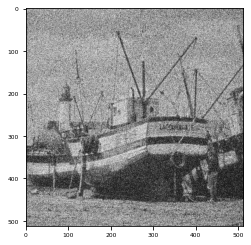

In [458]:
mask = np.zeros((fimg.shape))
h, w = fimg.shape
mask[0:int(h/2),0:int(w/2)] = 1.
I = mask*a
b= IDCT2(I )
plt.imshow(b,cmap='gray')

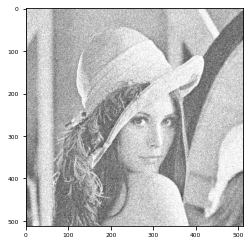

In [427]:
plt.imshow(b,cmap='gray')

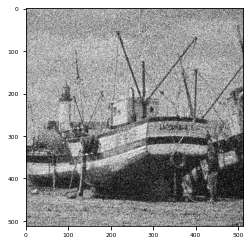

In [454]:
plt.imshow(all_img[2], cmap='gray')